In [1]:
from binance.client import Client
import pandas as pd

API_KEY = ''
API_SECRET = ''
client = Client(API_KEY, API_SECRET)

symbol = 'ALGOUSDT'

In [16]:
def binanceDataFrame(klines):
    df = pd.DataFrame(klines,dtype=float, columns = ('Open Time',
                                                                    'open',
                                                                    'high',
                                                                    'low',
                                                                    'close',
                                                                    'volume',
                                                                    'Close time',
                                                                    'Quote asset volume',
                                                                    'Number of trades',
                                                                    'Taker buy base asset volume',
                                                                    'Taker buy quote asset volume',
                                                                    'Ignore'))

    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df = df.set_index('Open Time')
    
    return df

new_date_load = True
if new_date_load:
    candlesticks = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_5MINUTE, '1 year')#"31 Aug, 2021", "1 Sep, 2021")
    df = binanceDataFrame(candlesticks)
else:
    
    df = pd.read_csv(symbol+"2months"+".csv")
    df['Open Time'] = pd.to_datetime(df['Open Time'])
    df = df.set_index('Open Time')



In [17]:
# df.to_csv(symbol+"2months"+".csv")

In [18]:
import backtrader as bt
import datetime as dt

import backtrader as bt
import backtrader.indicators as btind

# #Add data feed to Cerebro
data = bt.feeds.PandasData(dataname=df)


In [19]:
from sklearn.linear_model import LinearRegression


In [20]:
def printTradeAnalysis(cerebro, analyzers):
    print('Backtesting Results')
    if hasattr(analyzers, 'ta'):
        ta = analyzers.ta.get_analysis()

        openTotal         = ta.total.open          
        closedTotal       = ta.total.closed        
        wonTotal          = ta.won.total           
        lostTotal         = ta.lost.total          

        streakWonLongest  = ta.streak.won.longest  
        streakLostLongest = ta.streak.lost.longest 

        pnlNetTotal       = ta.pnl.net.total       
        pnlNetAverage     = ta.pnl.net.average     

        print('Open Positions', openTotal  )
        print('Closed Trades',  closedTotal)
        print('Winning Trades', wonTotal   )
        print('Loosing Trades', lostTotal  )
       

        print('Longest Winning Streak',   streakWonLongest )
        print('Longest Loosing Streak',   streakLostLongest)
        print('Strike Rate (Win/closed)', (wonTotal / closedTotal) * 100 if wonTotal and closedTotal else 0)
        

#         print(format, 'Inital Portfolio Value', '${}'.format(100))
        print( 'Final Portfolio Value',  '${}'.format(cerebro.broker.getvalue()))
        print( 'Net P/L',                '${}'.format(round(pnlNetTotal,   2)) )
        print( 'P/L Average per trade',  '${}'.format(round(pnlNetAverage, 2)))
        print('\n')

    if hasattr(analyzers, 'drawdown'):
        print('Drawdown', '${}'.format(analyzers.drawdown.get_analysis()['drawdown']))
    if hasattr(analyzers, 'sharpe'):
        print( 'Sharpe Ratio:', analyzers.sharpe.get_analysis()['sharperatio'])
    if print(analyzers, 'vwr'):
        print( 'VRW', analyzers.vwr.get_analysis()['vwr'])
    if hasattr(analyzers, 'sqn'):
        print( 'SQN', analyzers.sqn.get_analysis()['sqn'])
    print('\n')

    print('Transactions')
    print( 'Date', 'Amount', 'Price', 'SID', 'Symbol', 'Value')
    for key, value in analyzers.txn.get_analysis().items():
        print( key.strftime("%Y/%m/%d %H:%M:%S"), value[0][0], value[0][1], value[0][2], value[0][3], value[0][4])


In [21]:
"""
Defines class / functions tools for strategies.
"""
import backtrader as bt



In [22]:

class firstStrategy(bt.Strategy):
    params = (
        ('rsi_period',21),
        ('fast_rsi_period',8),
        ('ema_period',13),
        ('stop_loss',1),
        ('ema1',20),
        ('ema2',50),
        ('ema3',200),

    )
    def __init__(self):
        self.startcash = self.broker.getvalue()
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.rsi_fast = bt.indicators.RSI(self.data.close, period=8)
        self.ema1 = bt.indicators.EMA(self.data.close, period=self.params.ema1) 
        self.ema2 = bt.indicators.EMA(self.data.close, period=self.params.ema2) 

        self.ema3 = bt.indicators.EMA(self.data.close, period=self.params.ema3) 


        self.o_li = list()

        # To keep track of pending orders
        self.order = None  
        self.stopOrder = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
#         dt = dt or self.datas[0].datetime.datetime(0)
# #         print('%s, %s' % (dt.isoformat(), txt))
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

#         self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash

        if order.status in [order.Completed]:
#             if order.isbuy():
#                 self.log(f'BUY EXECUTED, {order.executed.price:.5f}')
# #                 stop_price = order.executed.price * (1.0 - self.params.stop_loss)
# #                 self.sell(exectype=bt.Order.Stop, price=stop_price)
#             elif order.issell():
#                 self.log(f'SELL EXECUTED, {order.executed.price:.5f}')
#                 self.log
            self.bar_executed = len(self)

        
    def next(self):

        if not self.position:
            if self.rsi<30 and self.data.close[0]>self.ema3:
                size = 1000/self.datas[0].close[0]

                self.order = self.buy(price=(self.datas[0].close[0]),exectype=bt.Order.Market,size=size)
#             if self.rsi>70 and self.order.Completed:
#                 self.order = self.sell(price=(self.datas[0].close[0]),exectype=bt.Order.Market,size=1000)

        else:
            if self.order and (self.data.close - self.order.price)!=0.0:
                change = (self.data.close - self.order.price)/self.order.price
                if change>0.008 or change<-0.008:
#                     print("selling at change:", change)
                    self.sell()

    def stop(self):
        pnl = round(self.broker.getvalue() - 2000,2)
        print('RSI Period: {} EMA1: {} EMA2 : {} EMA3: {} Final PnL: {}'.format(
            self.params.rsi_period, self.params.ema1,self.params.ema2,self.params.ema3,pnl))

In [23]:
import backtrader as bt
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
# ======================================================================================================================
# MAIN
# ======================================================================================================================

# Create an instance of cerebro
cerebro = bt.Cerebro(stdstats=False)

# Be selective about what we chart
#cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)

# Set the investment capital
cerebro.broker.setcash(2000)
cerebro.broker.setcommission(.001)

# Set position size
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

# Add our strategy
cerebro.addstrategy(firstStrategy , rsi_period=11, ema1 = (20),ema2 = (100), ema3 = (200))
# cerebro.optstrategy(firstStrategy, rsi_period=(8,9,10,11,12,13,14,1))

cerebro.adddata(data)


# Add analyzers
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0, annualize=True, timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.VWR, _name='vwr')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='txn')
# # Run our Backtest
backtest = cerebro.run(maxcpus=1)
backtest_results = backtest[0]



RSI Period: 11 EMA1: 20 EMA2 : 100 EMA3: 200 Final PnL: -185.15


<IPython.core.display.Javascript object>


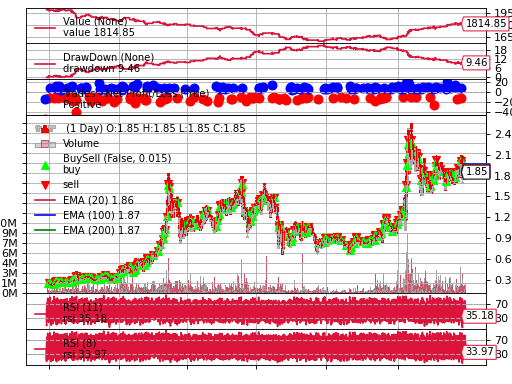

In [24]:
figure = cerebro.plot(style ='candlebars')[0][0]
figure.savefig('example.png')

In [25]:
printTradeAnalysis(cerebro,backtest_results.analyzers)

Backtesting Results
Open Positions 0
Closed Trades 204
Winning Trades 117
Loosing Trades 87
Longest Winning Streak 7
Longest Loosing Streak 8
Strike Rate (Win/closed) 57.35294117647059
Final Portfolio Value $1814.8504520569104
Net P/L $-185.15
P/L Average per trade $-0.91


Drawdown $9.457983360302672
Sharpe Ratio: -0.8158307712083859
<backtrader.metabase.ItemCollection object at 0x0000021B042D06A0> vwr
SQN -1.1305903847203063


Transactions
Date Amount Price SID Symbol Value
2020/10/31 15:15:00 3878.975950349108 0.2582 0  -1001.5515903801397
2020/10/31 18:55:00 -3878.975950349108 0.2553 0  990.3025601241275
2020/11/02 04:40:00 3888.0248833592536 0.2571 0  -999.611197511664
2020/11/02 06:35:00 -3888.0248833592536 0.2594 0  1008.5536547433904
2020/11/05 06:40:00 4111.8421052631575 0.2431 0  -999.5888157894736
2020/11/05 07:25:00 -4111.8421052631575 0.2408 0  990.1315789473682
2020/11/06 15:10:00 3799.392097264438 0.2637 0  -1001.8996960486322
2020/11/06 15:20:00 -3799.392097264438 0.266

2021/06/05 05:40:00 955.65749235474 1.047 0  -1000.5733944954128
2021/06/05 06:10:00 -955.65749235474 1.0562 0  1009.3654434250765
2021/06/05 09:40:00 942.8625306430323 1.0607 0  -1000.0942862530643
2021/06/05 09:50:00 -942.8625306430323 1.0454 0  985.6684895342261
2021/06/07 14:50:00 950.0285008550256 1.0524 0  -999.809994299829
2021/06/07 15:25:00 -950.0285008550256 1.0613 0  1008.2652479574386
2021/06/09 18:40:00 960.4302727621975 1.0413 0  -1000.0960430272762
2021/06/09 19:15:00 -960.4302727621975 1.0298 0  989.0510948905111
2021/06/09 19:30:00 970.8737864077669 1.0305 0  -1000.4854368932038
2021/06/09 21:00:00 -970.8737864077669 1.0208 0  991.0679611650485
2021/06/11 06:20:00 961.4460148062686 1.0404 0  -1000.2884338044419
2021/06/11 07:00:00 -961.4460148062686 1.0314 0  991.6354196711856
2021/06/11 07:05:00 971.1566475672525 1.0294 0  -999.7086530057298
2021/06/11 07:35:00 -971.1566475672525 1.042 0  1011.9452267650772
2021/06/13 03:10:00 1011.4291493880853 0.9888 0  -1000.101142

In [26]:
# cerebro.optstrategy(firstStrategy,  rsi_period=14, ema1 = (10,20),ema2 = (50,100), ema3 = (200))
# opt_runs = cerebro.run(maxcpus = 1)

# # Generate results list
# final_results_list = []
# for run in opt_runs:
#     for strategy in run:
#         value = round(strategy.broker.get_value(),2)
#         PnL = round(value - startcash,2)
#         period = strategy.params.period
#         final_results_list.append([period,PnL])

# #Sort Results List
# by_period = sorted(final_results_list, key=lambda x: x[0])
# by_PnL = sorted(final_results_list, key=lambda x: x[1], reverse=True)

# #Print results
# print('Results: Ordered by period:')
# for result in by_period:
#     print('Period: {}, PnL: {}'.format(result[0], result[1]))
# print('Results: Ordered by Profit:')
# for result in by_PnL:
#     print('Period: {}, PnL: {}'.format(result[0], result[1]))